In [1]:
%matplotlib inline

# Introduction

The following is a decision tree model trained to differentiate between 5400 blue +'s and 5400 red x's. 

# Import Dependencies

We begin by importing the necessary libraries.

In [2]:
# Utility
import random
from random import seed
from random import randrange

# Data analysis
import numpy as np
import pandas as pd

# Data visualization
from tqdm import tqdm
import matplotlib.pyplot as plt

# Data Generation

Then, we generate the training/test data based on the following distributions:
*   5000 blue +'s following a Gaussian distribution, centered at `(10, 10)`
*   400 blue +'s following a uniform distribution within the range `[0, 20)`
*   5400 red x's following a uniform distribution within the range `[0, 20)`

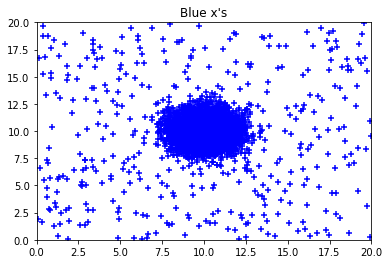

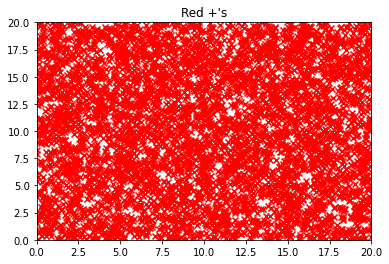

In [3]:
# Generate blue +'s
x1 = [(np.random.normal(loc=10), np.random.normal(loc=10)) for _ in range(5000)]
x1.extend([(np.random.uniform(high=20), np.random.uniform(high=20)) for _ in range(400)])

# Generate red x's
x2 = [(np.random.uniform(high=20), np.random.uniform(high=20)) for _ in range(5400)]

# Visualize data
plt.scatter([x[0] for x in x1], [y[1] for y in x1], c='b', marker='+')
plt.title('Blue x\'s')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

plt.scatter([x[0] for x in x2], [y[1] for y in x2], c='r', marker='x')
plt.title('Red +\'s')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

Once our data has been generated, we create a DataFrame to store our coordinates and labels (0: blue +'s, 1: red x's).

In [4]:
# Combine the blue +'s and red x's
x1.extend(x2)
X = x1
X_list = [list(ele) for ele in X]
# Generate labels 
y = [0 for _ in range(5400)]
y.extend([1 for _ in range(5400)])

# Append labels to coordinates
for i, j in zip(X_list, y):
  i.append(j)

data_df = pd.DataFrame(X_list, 
                       columns = ['X', 'Y', 'Labels'])

In [5]:
# Shuffle and display the DataFrame
data_df = data_df.sample(frac=1).reset_index(drop=True)

train = data_df.sample(frac=0.2, random_state=200)
test = data_df.drop(train.index)

# DataFrame into list
df_list = data_df.values.tolist()

# Build Decision Tree

In [6]:
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# Count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# Sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# Avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# Score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# Weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini
 
# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index': b_index, 'value': b_value, 'groups': b_groups}
 
# Create a terminal node value
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], max_depth, min_size, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], max_depth, min_size, depth+1)
 
# Build a decision tree
def build_tree(train, max_depth, min_size):
	root = get_split(train)
	split(root, max_depth, min_size, 1)
	return root
 
# Print a decision tree
def print_tree(node, depth=0):
	if isinstance(node, dict):
		print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
		print_tree(node['left'], depth+1)
		print_tree(node['right'], depth+1)
	else:
		print('%s[%s]' % ((depth*' ', node)))


# K-fold Cross Validation and Accuracy



In [7]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0
 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores
 
# Make a prediction with a decision tree
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']
 
# Classification and Regression Tree Algorithm
def decision_tree(train, test, max_depth, min_size):
	tree = build_tree(train, max_depth, min_size)
	predictions = list()
	for row in test:
		prediction = predict(tree, row)
		predictions.append(prediction)
	return(predictions)
 
seed(1)
dataset = df_list
# Evaluate algorithm
n_folds = 5
max_depth = 4
min_size = 4
scores = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [92.36111111111111, 91.48148148148148, 91.89814814814815, 92.22222222222223, 92.45370370370371]
Mean Accuracy: 92.083%


Note that because of the random noise, achieving 100% accuracy is impossible (the max accuracy is 92.593%).

# Visualize the Tree

Let's visualize the final (optimized) decision tree (left child: top, right child: bottom).

In [8]:
tree = build_tree(df_list, max_depth, min_size)
print_tree(tree)

[X2 < 12.192]
 [X2 < 8.065]
  [X2 < 7.609]
   [X2 < 6.327]
    [1.0]
    [1.0]
   [X1 < 11.976]
    [0.0]
    [1.0]
  [X1 < 7.234]
   [X1 < 6.396]
    [1.0]
    [1.0]
   [X1 < 12.577]
    [0.0]
    [1.0]
 [X2 < 12.830]
  [X1 < 7.128]
   [X2 < 12.779]
    [1.0]
    [1.0]
   [X1 < 11.595]
    [0.0]
    [1.0]
  [X2 < 13.290]
   [X2 < 13.130]
    [1.0]
    [1.0]
   [X1 < 17.358]
    [1.0]
    [1.0]
